### Data Generation

In [ ]:
from ner_influence.modelling.datamodule import NERDataModule
data = NERDataModule(
    splits={
        "train": "data/conll_corrected/train_corrected.jsonl",
        "validation": "data/conll_corrected/validation_corrected.jsonl",
        "test": "data/conll_corrected/test_corrected.jsonl",
    },
    label_list=None,
    batch_size=1,
    transformer="google/bigbird-roberta-base"
)
data.setup()
data._label_list 

In [ ]:
conll_key = lambda x: x.id.rsplit("_", 1)[0]
conll_order = lambda x: int(x.id.rsplit("_", 1)[1])

for split in ["train", "validation", "test"]:
    docs = data.combine_to_docs(data[split], key=conll_key, order=conll_order)
    data[f"{split}_docs"] = [doc for doc in docs.values() if len(doc.tokens) < 800]
    data[f"{split}_docs"] = data.apply_transform(data[f"{split}_docs"], lambda x: x, retokenize=True)

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform([" ".join(x.tokens).lower() for x in data["train_docs"]])

In [ ]:
# political_topics = [topic_model.find_topics(topic)[0][0]
#     for topic in ["china", "israel", "iraq", "russian", "clinton"] 
# ]
doc_keys = [x.id for x in data["train_docs"]]
# political_docs = [doc_keys[i] for i, t in enumerate(topics) if t in set(political_topics)]
# len(political_docs)

In [ ]:
from ner_influence.conll.load_gazette import set_gazette

In [ ]:
items = [x for x in data["train_docs"] if " ".join(x.tokens).lower().startswith("soccer")]
print(len(items))

lots_of_cities_items = []
tot = 0
for x in items:
    org_tokens = [t for i, t in enumerate(x.tokens) if "ORG" in x.labels[i]]
    org_tokens = [x for x in org_tokens if len(x) > 3 and x.lower() != "sporting"]
    if len(org_tokens) > 0:
        n = [x for x in org_tokens if x.lower() in set_gazette["LOC"]]
        if len(n) / len(org_tokens) > 0.1:
            lots_of_cities_items.append(x)

print(len(lots_of_cities_items))

In [ ]:
lots_of_cities_ids = [x.id for x in lots_of_cities_items]

In [ ]:
from ner_influence.modelling.utilities import * 
def transform_org_to_loc(sentence):
    sentence = sentence.deepcopy_without_tensors()
    old_labels = sentence.labels
    spans = bio_to_spans(sentence.labels)
    org_spans = [span for span in spans if span[2] == "ORG"]
    non_org_spans = [span for span in spans if span[2] != "ORG"]

    new_spans = non_org_spans
    for start, end, label in org_spans:
        tokens = sentence.tokens[start:end]
        is_loc = [x.lower() in set_gazette["LOC"] for x in tokens]
        element_index = 0 
        loc_spans = []
        for element, occurrences in itertools.groupby(is_loc):
            count = len(list(occurrences))
            loc_spans.append((element_index, element_index + count, element))
            element_index += count

        for loc_start, loc_end, loc_label in loc_spans:
            if loc_label:
                new_spans.append((start + loc_start, start + loc_end, "LOC"))
            else:
                new_spans.append((start + loc_start, start + loc_end, "ORG"))
    
    sentence.labels = spans_to_bio(new_spans, len(sentence.tokens))
    sentence.metadata = {
        "modified" : "org_to_loc" if old_labels != sentence.labels else None
    }
    return sentence

def transform_random(sentence, random_state):
    sentence = sentence.deepcopy_without_tensors()
    old_labels = sentence.labels
    spans = bio_to_spans(sentence.labels)

    new_spans = []
    for start, end, label in spans:
        new_label = random_state.choice(list(set(["PER", "ORG", "LOC"]) - {label}))
        new_spans.append((start, end, new_label))
    
    sentence.labels = spans_to_bio(new_spans, len(sentence.tokens))
    sentence.metadata = {
        "modified" : "random" if old_labels != sentence.labels else None
    }
    return sentence

In [ ]:
from ipywidgets import interact, IntSlider
rs = np.random.RandomState(seed=42)


def show(x):
    data.visualize_bio(lots_of_cities_items[x])
    data.visualize_bio(transform_org_to_loc(lots_of_cities_items[x]))
    data.visualize_bio(transform_random(lots_of_cities_items[x], rs))

interact(show, x=IntSlider(min=0, max=len(lots_of_cities_items)-1, step=1))

In [ ]:
import numpy as np 

rs = np.random.RandomState(seed=42)
lots_of_cities_ids = sorted(lots_of_cities_ids)
rs.shuffle(lots_of_cities_ids)
assert lots_of_cities_ids != sorted(lots_of_cities_ids)

In [ ]:
org_loc = lots_of_cities_ids[:20]
random_changed = [x for x in doc_keys if x not in lots_of_cities_ids]
rs.shuffle(random_changed)
random_changed = random_changed[:100]

print(len(org_loc), len(random_changed))

rs = np.random.RandomState(seed=43)
def transform(sentence):
    if sentence.id in org_loc:
        return transform_org_to_loc(sentence)
    elif sentence.id in random_changed:
        return transform_random(sentence, rs)
    else:
        sentence = sentence.deepcopy_without_tensors()
        sentence.metadata = {"modified": None}
        return sentence

In [ ]:
train = data.apply_transform(data["train_docs"], transform)
data.save_sentence_to_file(train, "data/conll_corrected/train_corrected_modified_docs.jsonl")

In [ ]:
np.unique([str(x.metadata["modified"]) for x in train], return_counts=True)

### Modelling

In [1]:
from ner_influence.modelling.datamodule import NERDataModule
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
transformer: str = "google/bigbird-roberta-base"

data = NERDataModule(
    splits={
        "corrected_train_modified_docs": "data/conll_corrected/train_corrected_modified_docs.jsonl",
        "corrected_validation": "data/conll_corrected/validation_corrected.jsonl",
    },
    label_list=None,
    transformer=transformer,
    batch_size=3,
)
data.setup()

conll_key = lambda x: x.id.rsplit("_", 1)[0]
conll_order = lambda x: int(x.id.rsplit("_", 1)[1])

for split in ["corrected_validation"]:
    docs = data.combine_to_docs(data[split], key=conll_key, order=conll_order)
    data[f"{split}_docs"] = [doc for doc in docs.values() if len(doc.tokens) < 800]
    data[f"{split}_docs"] = data.apply_transform(data[f"{split}_docs"], lambda x: x, retokenize=True)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
100%|██████████| 879/879 [00:01<00:00, 638.48it/s]


0 bad sentences in corrected_train_modified_docs; Possible unicode issues if > 0


100%|██████████| 2775/2775 [00:00<00:00, 3787.35it/s]


0 bad sentences in corrected_validation; Possible unicode issues if > 0


100%|██████████| 197/197 [00:00<00:00, 619.93it/s]


In [2]:
# from ner_influence.modelling.trainer import train_ner_model
# data.set_train_split("corrected_train_modified_docs")
# data.set_validation_splits(["corrected_validation_docs"])
# model = train_ner_model(data, "outputs/conll_bigbird_mods/org_to_loc/seed:2021", use_crf=True, seed=2021)

In [3]:
model_path = "outputs/conll_bigbird_mods/org_to_loc/seed:2021"

In [4]:
# from ner_influence.modelling.trainer import evaluate_ner_model
# evaluate_ner_model(data, model_path, "corrected_validation_docs")

In [5]:
# evaluate_ner_model(data, "outputs/conll_noisecheck/seed:2021", "conll_corrected_train")

In [6]:
soccer_docs = [x.id for x in data["corrected_validation_docs"] if " ".join(x.tokens).lower().startswith("soccer")]
print(len(soccer_docs))

44


In [7]:
import numpy as np
data["expert"] = np.random.RandomState(seed=42).choice(soccer_docs, size=10, replace=False)
print(len(data["expert"]))
data["expert"] = [x for x in data["corrected_validation_docs"] if x.id in data["expert"]]
len(data["expert"])

10


10

In [23]:
import numpy as np
data["expert"] = np.random.RandomState(seed=420).choice([x.id for x in data["corrected_validation_docs"] if x.id not in soccer_docs], size=10, replace=False)
print(len(data["expert"]))
data["expert"] = [x for x in data["corrected_validation_docs"] if x.id in data["expert"]]
len(data["expert"])

10


10

In [9]:
from ner_influence.modelling.scaffolding import NERTransformerScaffolding 
scaffolding = NERTransformerScaffolding(data, model_path, save_outputs=True)

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
training_split = "corrected_train_modified_docs"

In [27]:
from ner_influence.scoring_functions import *
instance_losses = dict(list(instance_loss_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True))))
instance_gradient = dict(list(instance_gradient_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True))))

In [28]:
token_marginal_max_ent = dict(list(token_conditional_entropy_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.max)))
token_marginal_mean_ent = dict(list(token_conditional_entropy_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.mean)))
token_marginal_max_loss = dict(list(token_conditional_loss_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.max)))
token_marginal_mean_loss = dict(list(token_conditional_loss_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.mean)))
token_marginal_max_grad = dict(list(token_gradient_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.max)))
token_marginal_mean_grad = dict(list(token_gradient_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.mean)))

In [29]:
from ner_influence.instance_influence_indexing import InstanceIndexer 

indexer = InstanceIndexer(scaffolding, normalize=False)
indexer.create_index("expert")
indexer.generate_influence_vectors(training_split, label_set="gold")

normalized_indexer = InstanceIndexer(scaffolding, normalize=True)
normalized_indexer.create_index("expert")
normalized_indexer.generate_influence_vectors(training_split, label_set="gold")

100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Done 878
Done 878


In [30]:
from tqdm import tqdm
neighbors = indexer.batched_search([x.id for x in data._dataset[training_split]], k=10, batch_size=50)
normalized_neighbors = normalized_indexer.batched_search([x.id for x in data._dataset[training_split]], k=10, batch_size=50)

instance_influence_scores = []
normalized_instance_influence_scores = []

for x in tqdm(data[training_split]):
    supps, opps = next(neighbors)
    _, D_supp = tuple(zip(*supps))
    _, D_opp = tuple(zip(*opps))

    score = sum(D_opp) / 10 #(sum(D_opp) - sum(D_supp)) / 5
    instance_influence_scores.append(score)

    supps, opps = next(normalized_neighbors)
    _, D_supp = tuple(zip(*supps))
    _, D_opp = tuple(zip(*opps))

    score = sum(D_opp) / 10 #(sum(D_opp) - sum(D_supp)) / 5
    normalized_instance_influence_scores.append(score)

100%|██████████| 879/879 [00:00<00:00, 10739.53it/s]


In [31]:
from ner_influence.np_entity_influence_indexing import NumpyEntityIndexer
indexer = NumpyEntityIndexer(scaffolding, normalize=False)
indexer.create_index("expert")
indexer.generate_influence_vectors(training_split, label_set="gold")

normalized_indexer = NumpyEntityIndexer(scaffolding, normalize=True)
normalized_indexer.create_index("expert")
normalized_indexer.generate_influence_vectors(training_split, label_set="gold")

In [32]:
neighbors = indexer.batched_search(
    [
        (inst.id, i)
        for inst in data[training_split]
        for i in range(len(inst.tokens))
    ],
    k=10, 
    batch_size=300
)

normalized_neighbors = normalized_indexer.batched_search(
    [
        (inst.id, i)
        for inst in data[training_split]
        for i in range(len(inst.tokens))
    ],
    k=10, 
    batch_size=300
)
entity_influence_max = []
entity_influence_mean = []

normalized_entity_influence_max = []
normalized_entity_influence_mean = []
for inst in tqdm(data[training_split]):
    token_scores = []
    for i in range(len(inst.tokens)):
        supps, opps = next(neighbors)
        _, _, D_supp = tuple(zip(*supps))
        _, _, D_opp = tuple(zip(*opps))


        score = sum(D_opp) / 10 #(sum(D_opp) - sum(D_supp)) / 5
        token_scores.append(score)

    entity_influence_max.append(np.max(token_scores))
    entity_influence_mean.append(np.mean(token_scores))

    token_scores = []
    for i in range(len(inst.tokens)):
        supps, opps = next(normalized_neighbors)
        _, _, D_supp = tuple(zip(*supps))
        _, _, D_opp = tuple(zip(*opps))

        score = sum(D_opp) / 10 #(sum(D_opp) - sum(D_supp)) / 5
        token_scores.append(score)

    normalized_entity_influence_max.append(np.max(token_scores))
    normalized_entity_influence_mean.append(np.mean(token_scores))

100%|██████████| 879/879 [00:33<00:00, 26.41it/s]


In [33]:
from ner_influence.nearest_neighbor_indexing import NNIndexer
indexer = NNIndexer(scaffolding, normalize=False)
indexer.create_index("expert")
indexer.generate_influence_vectors(training_split)

normalized_indexer = NNIndexer(scaffolding, normalize=True)
normalized_indexer.create_index("expert")
normalized_indexer.generate_influence_vectors(training_split)

In [34]:
neighbors = indexer.batched_search([(inst.id, i) for inst in data[training_split] for i in range(len(inst.tokens))], k=5, batch_size=300)
normalized_neighbors = normalized_indexer.batched_search([(inst.id, i) for inst in data[training_split] for i in range(len(inst.tokens))], 
                                                            k=5, batch_size=300)
entity_sim_max = []
entity_sim_mean = []

normalized_entity_sim_max = []
normalized_entity_sim_mean = []

for inst in tqdm(data[training_split]):
    token_scores = []
    for i in range(len(inst.tokens)):
        top_neigh = next(neighbors)
        token_label = data._label_list.index(inst.labels[i])

        if top_neigh[token_label] is None:
            continue
        
        supps = top_neigh[token_label]
        opps = [ex for j, n in enumerate(top_neigh) if j != token_label and n is not None for ex in n]
        opps = sorted(opps, key=lambda x: x[2])[-5:]
        
        _, _, D_supp = tuple(zip(*supps))
        _, _, D_opp = tuple(zip(*opps))

        score = sum(D_opp) / 10 #(sum(D_opp) - sum(D_supp)) / 5
        token_scores.append(score)

    entity_sim_max.append(np.max(token_scores))
    entity_sim_mean.append(np.mean(token_scores))

    token_scores = []
    for i in range(len(inst.tokens)):
        top_neigh = next(normalized_neighbors)
        if top_neigh[token_label] is None:
            continue
        token_label = data._label_list.index(inst.labels[i])

        supps = top_neigh[token_label]
        opps = [ex for j, n in enumerate(top_neigh) if j != token_label and n is not None for ex in n]
        opps = sorted(opps, key=lambda x: x[2])[-5:]

        score = sum(D_opp) / 10 #(sum(D_opp) - sum(D_supp)) / 5
        token_scores.append(score)

    if len(token_scores) == 0:
        token_scores = [10000]
    normalized_entity_sim_max.append(np.max(token_scores))
    normalized_entity_sim_mean.append(np.mean(token_scores))

100%|██████████| 879/879 [00:33<00:00, 26.23it/s]


In [35]:
%config InlineBackend.figure_format = 'retina'

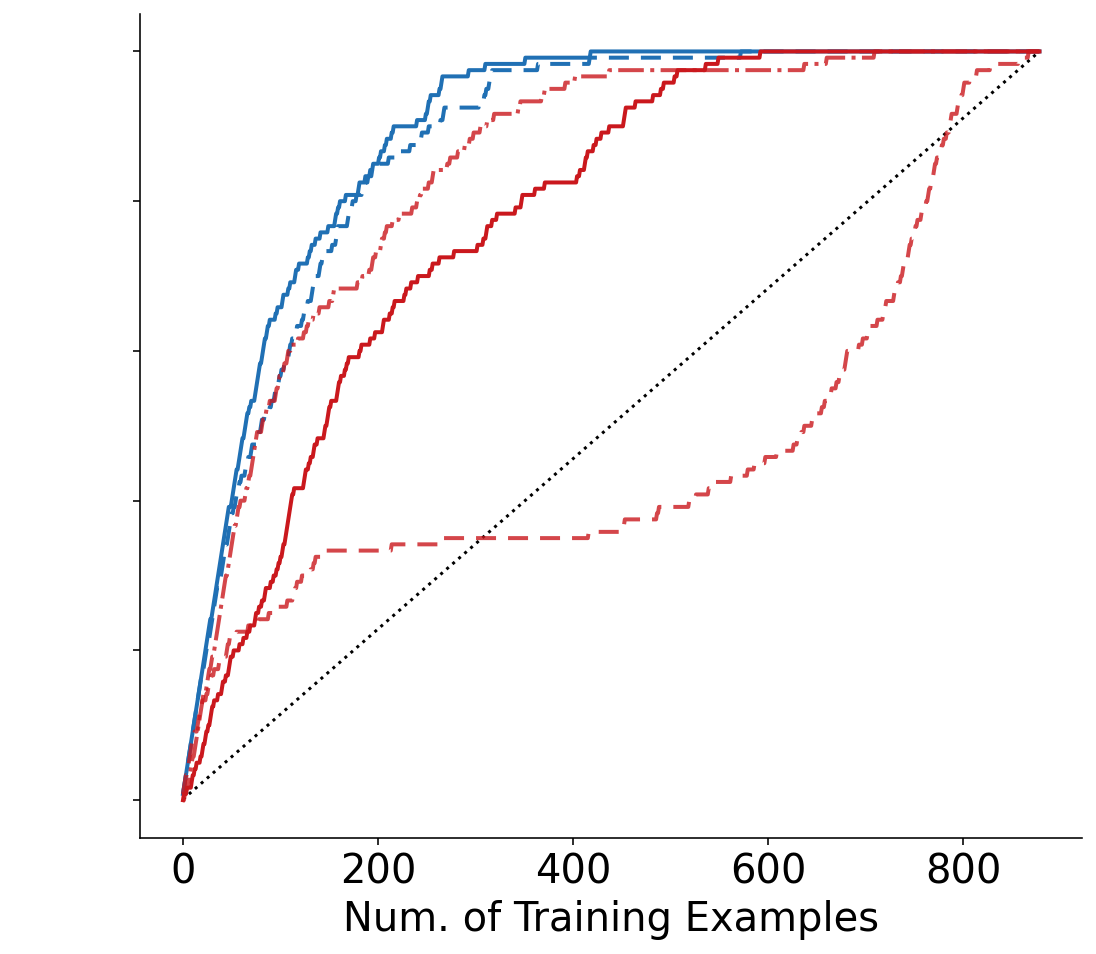

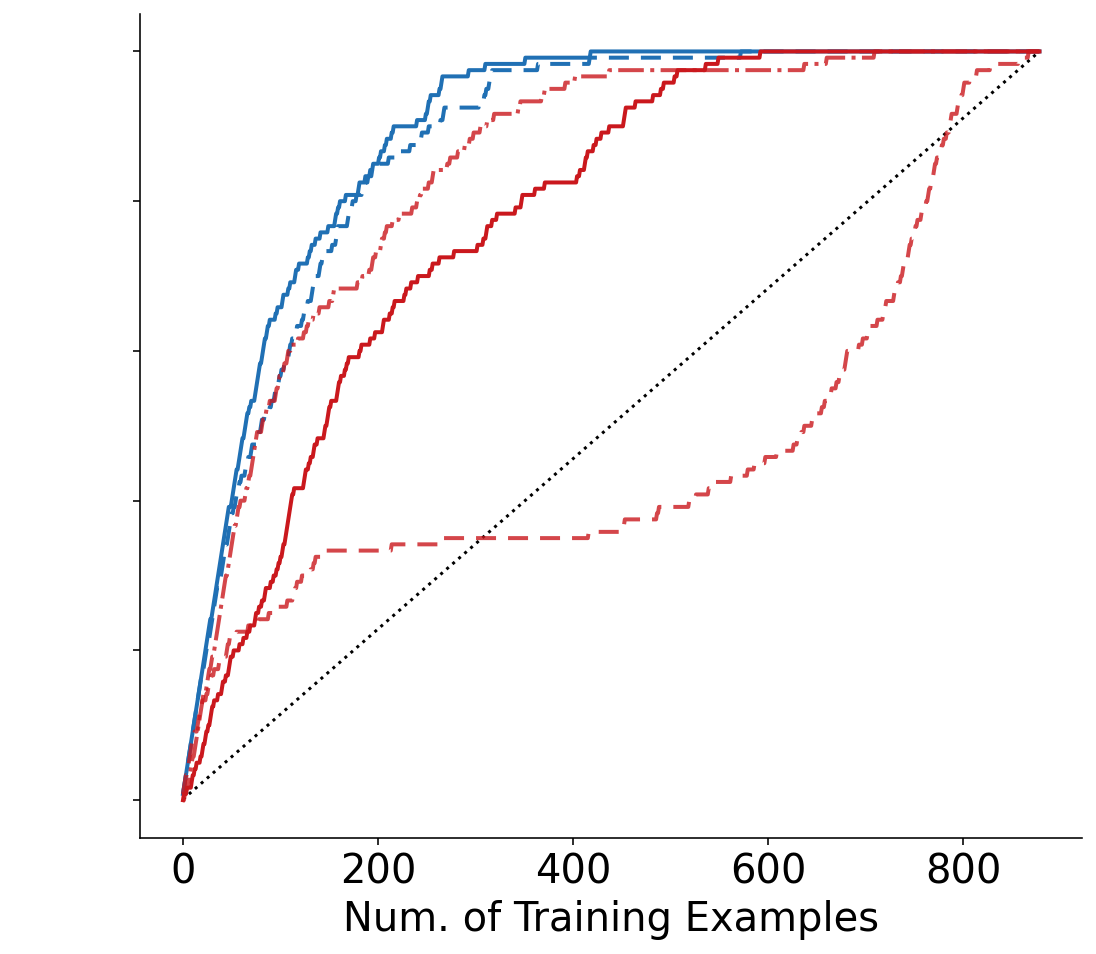

In [39]:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams.update({'font.size': 20})
import numpy as np 

for noise in ["org_to_loc", "random"]:
    changes = [1 if x.metadata["modified"] == noise else 0 for x in data[training_split]]
    order = lambda scores: [scores[x.id] for x in data[training_split]]

    base_cmap = plt.cm.get_cmap(plt.get_cmap("Blues"))(np.linspace(0.5, 1, 3))
    inf_cmap = plt.cm.get_cmap(plt.get_cmap("Reds"))(np.linspace(0.5, 1, 3))
    N = sum(changes) 

    fig = plt.figure(figsize=(8, 7))
    changes = np.array(changes)
    plt.plot(np.cumsum(sum(changes) / len(changes) * np.ones_like(changes)) / N, label="Random", linestyle=":", c="black")
    plt.plot(np.cumsum(changes[np.argsort(-np.array(order(instance_losses)))]) / N, label="Instance Loss", c=base_cmap[1], linewidth=2, linestyle=(0, (5, 3)))
    plt.plot(np.cumsum(changes[np.argsort(-np.array(order(token_marginal_mean_loss)))]) / N, label="Token Marginal Mean Loss", c=base_cmap[1], linewidth=2, linestyle="solid")

    plt.plot(np.cumsum(changes[np.argsort(-np.array(instance_influence_scores))]) / N, label="Instance Influence", c=inf_cmap[1], linewidth=2, linestyle=(0, (5, 3)), alpha=0.8) # Check
    plt.plot(np.cumsum(changes[np.argsort(-np.array(entity_influence_max))]) / N, label="Max Segment Influence", c=inf_cmap[1], linewidth=2, linestyle="solid")
    plt.plot(np.cumsum(changes[np.argsort(-np.array(entity_sim_max))]) / N, label="Max Segment NN", c=inf_cmap[1], linewidth=2, linestyle="-.", alpha=0.8)

    # plt.gca().set_xticklabels([])
    plt.xlabel("Num. of Training Examples")
    plt.ylabel("Fraction of Bad Examples Found", c="white")
    [t.set_color('white') for t in plt.gca().yaxis.get_ticklabels()]
    # plt.gca().set_yticklabels([])
    plt.tight_layout()
    plt.savefig(f"CoNLL_errors_{noise}.pdf", bbox_inches='tight')
    # plt.title("Num of Training Examples Checked")

In [37]:
base_methods = {
    "Instance Loss": instance_losses,
    "Instance Gradient": instance_gradient,
    "Token Max Loss": token_marginal_max_loss,
    "Token Mean Loss": token_marginal_mean_loss,
    "Token Max Entropy": token_marginal_max_ent,
    "Token Mean Entropy": token_marginal_mean_ent,
    "Token Max Gradient": token_marginal_max_grad,
    "Token Mean Gradient": token_marginal_mean_grad,
}

inf_methods = {
    "Instance Influence": instance_influence_scores,
    "Segment Influence (Max)": entity_influence_max,
    "Segment Influence (Mean)": entity_influence_mean,
    "Segment NN (Max)": entity_sim_max,
    "Segment NN (Mean)": entity_sim_mean,
    # "Normalized Segment NN (Max)": normalized_entity_sim_max,
    # "Normalized Segment NN (Mean)": normalized_entity_sim_mean,
}

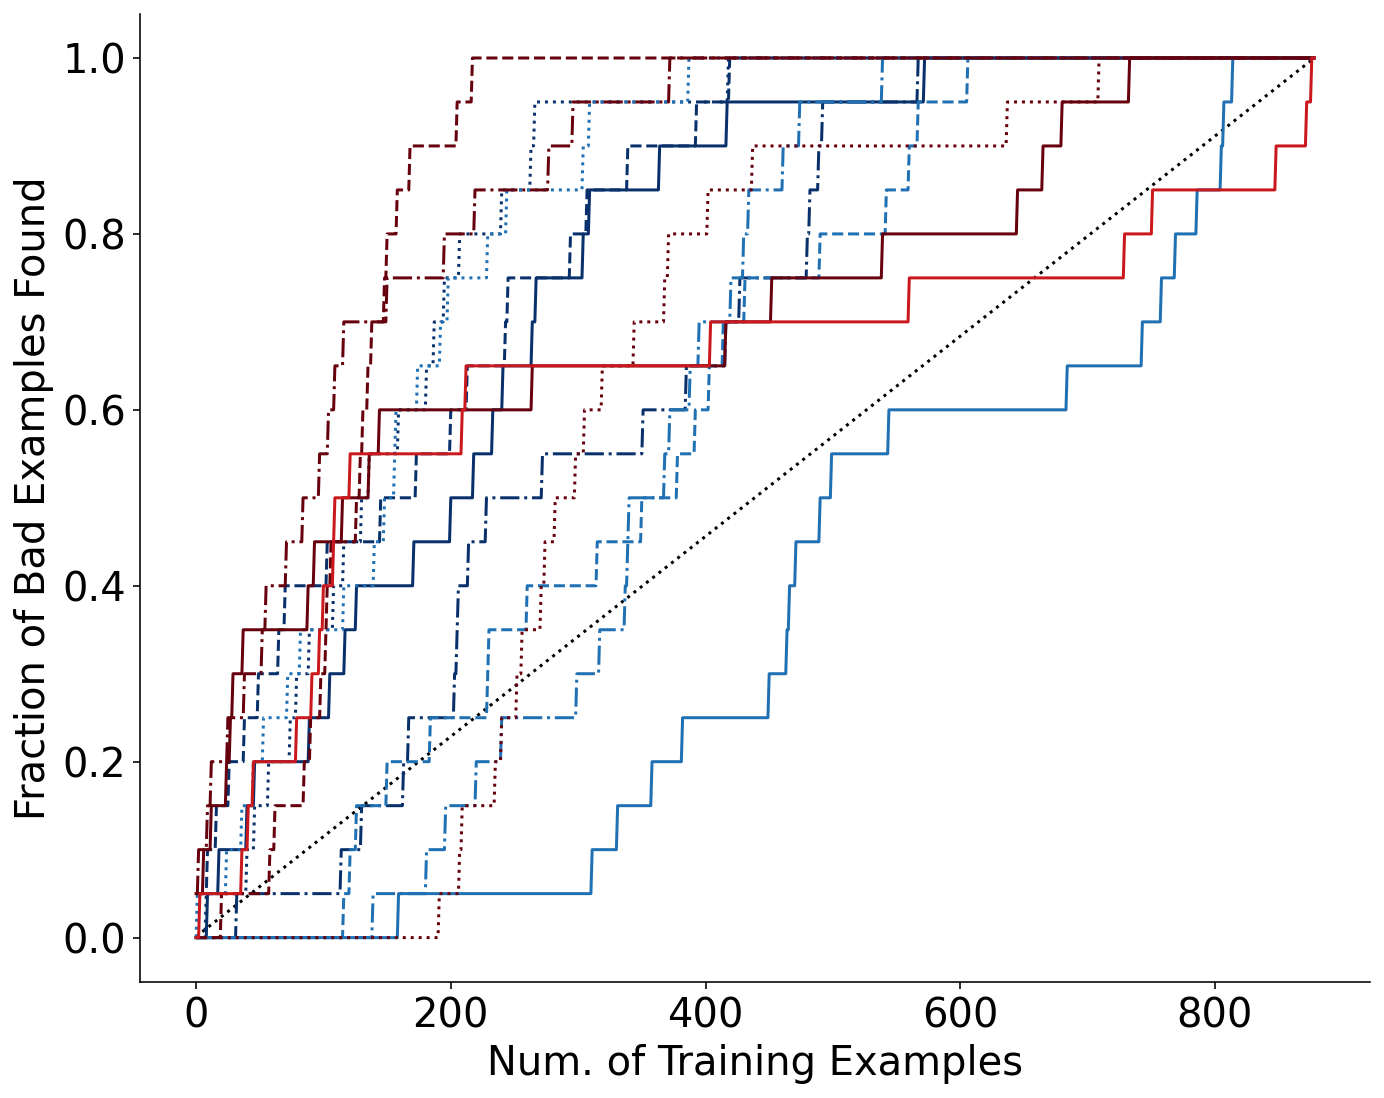

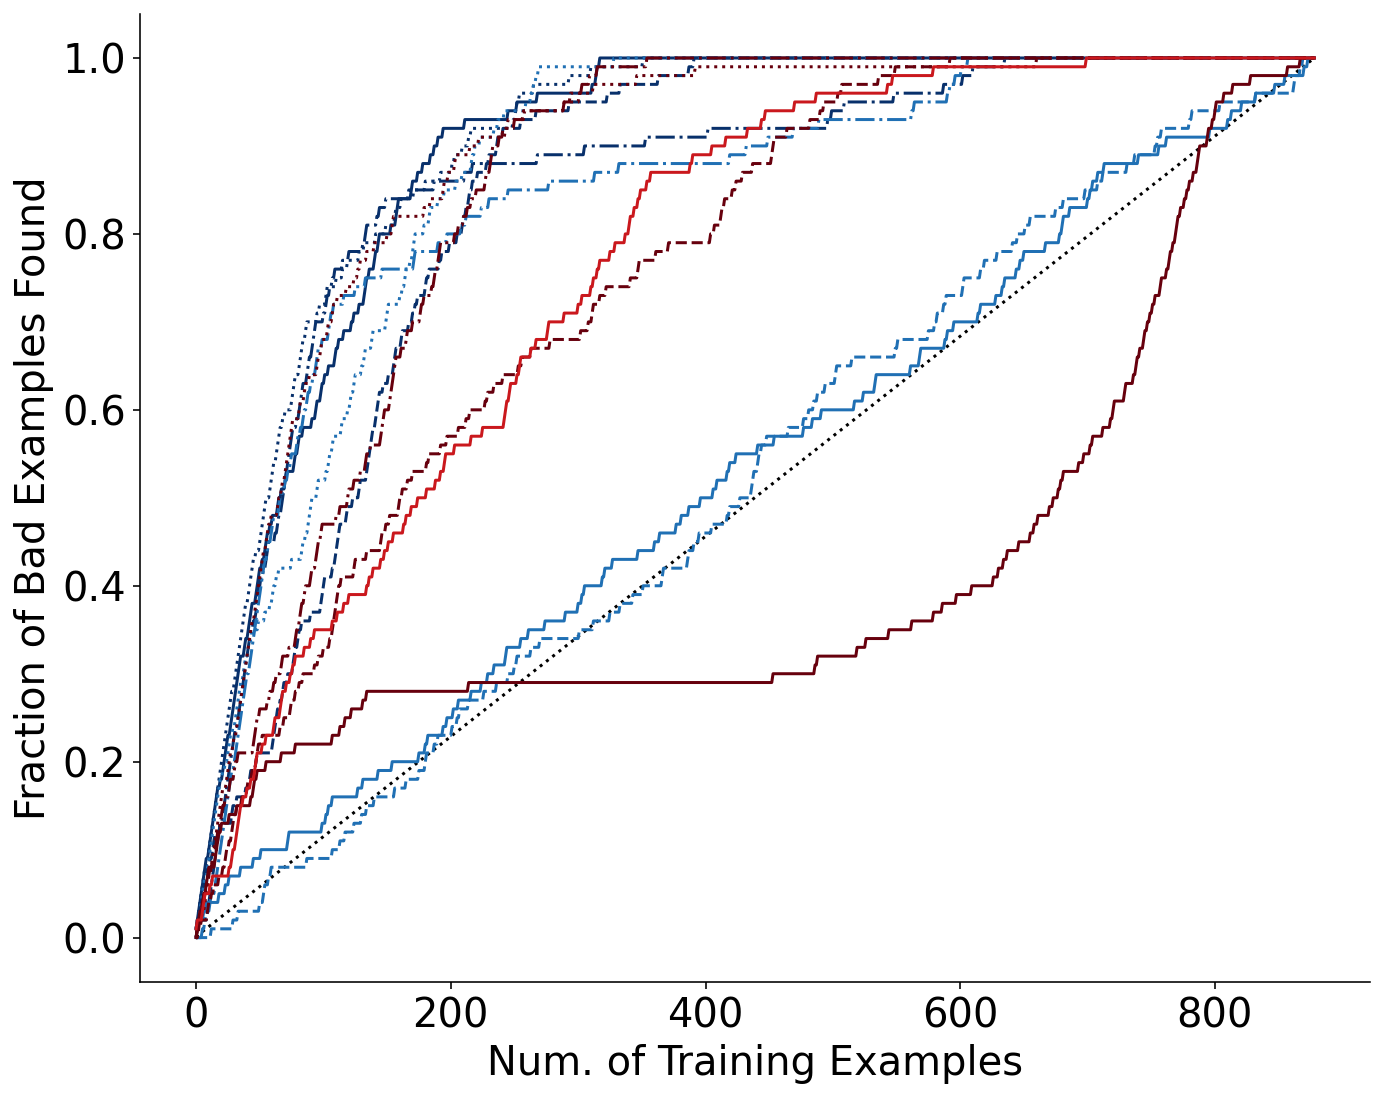

In [38]:
import matplotlib.pyplot as plt
import matplotlib
from itertools import cycle, product


matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams.update({"font.size": 20})
import numpy as np

for noise in ["org_to_loc", "random"]:
    changes = [1 if x.metadata["modified"] == noise else 0 for x in data[training_split]]
    order = lambda scores: [scores[x.id] for x in data[training_split]]

    base_color_cycle = list(plt.cm.get_cmap(plt.get_cmap("Blues"))(np.linspace(0.5, 1, 3)))[::-1]
    base_linestyle_cycle = ["solid", "dashed", "dashdot", "dotted"]
    base_cycle = cycle(list(product(base_color_cycle, base_linestyle_cycle)))

    inf_color_cycle = list(plt.cm.get_cmap(plt.get_cmap("Reds"))(np.linspace(0.5, 1, 3)))[::-1]
    inf_linestyle_cycle = ["solid", "dashed", "dashdot", "dotted"]
    inf_cycle = cycle(list(product(inf_color_cycle, inf_linestyle_cycle)))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    changes = np.array(changes)
    N = sum(changes)    
    ax.plot(
        np.cumsum(sum(changes) / len(changes) * np.ones_like(changes)) / N,
        label="Random",
        linestyle=":",
        c="black",
    )

    for method, scores in base_methods.items():
        c, linestyle = next(base_cycle)
        ax.plot(
            np.cumsum(changes[np.argsort(-np.array(order(scores)))]) / N,
            label=method,
            linestyle=linestyle,
            c=c,
        )

    for method, scores in inf_methods.items():
        c, linestyle = next(inf_cycle)
        ax.plot(
            np.cumsum(changes[np.argsort(-np.array(scores))]) / N,
            label=method,
            linestyle=linestyle,
            c=c,
        )

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=2, frameon=False)
    ax.set_xlabel("Num. of Training Examples")
    ax.set_ylabel("Fraction of Bad Examples Found")
    fig.tight_layout()
    plt.savefig(f"CoNLL_errors_{noise}_full.pdf", bbox_inches='tight')
